## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 5: Decision Trees


***Goals of this homework:***
Work with decision trees.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw3.ipynb**, so for example, my submission would be something like **555001234_hw3.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 2 cells:***
1. **[A Code Cell] Your Code:**
  - If code is not applicable for the question, you can skip this cell.
  - For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.

***At the end of each Section (A/B/C/...) include a cell for your resources:***

**[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [72pts]. Decision Trees

**Rubric**

[24 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[12 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


## Environment Setup & Sampling (Optional)

- You may use the full datasets. Sampling is optional (for speed).
- If you sample, briefly report what you did (n/frac, whether you stratified, any seed).


In [1]:
#!/bin/bash
! curl -L -o mushroom-classification.zip https://www.kaggle.com/api/v1/datasets/download/uciml/mushroom-classification
! unzip -o mushroom-classification.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0   0     0   0     0     0     0  --:--:-- --:--:-- --:--:--     0
100 35057 100 35057   0     0 112849     0  --:--:-- --:--:-- --:--:-- 112849
Archive:  mushroom-classification.zip
  inflating: mushrooms.csv           


In [2]:
##### sampling code (optional)
from pathlib import Path
import pandas as pd

# Edit paths if needed
MUSHROOM_PATH = Path("./mushrooms.csv")

def load_csv(path, **kwargs):
    if path.exists():
        return pd.read_csv(path, **kwargs)
    print(f"Warning: {path} not found.")
    return None

mushroom = load_csv(MUSHROOM_PATH)

# ====== (Optional) Sampling ======
# Leave all values as None to use the full dataset.
SAMPLE = {
    "mushroom": {"n": None, "frac": None, "random_state": None, "stratify_col": None},  # e.g., {"frac": 1.0}
}

def maybe_sample(df, cfg):
    """Return sampled df if n/frac set; otherwise return df. Optional stratify by a column name."""
    if df is None:
        return None
    n, frac, rs, strat = cfg.get("n"), cfg.get("frac"), cfg.get("random_state"), cfg.get("stratify_col")
    if strat and strat in df.columns and (n or frac):
        # stratified sampling (simple & proportional when using frac)
        if frac:
            return (df.groupby(strat, group_keys=False)
                      .apply(lambda g: g.sample(frac=frac, random_state=rs))
                      .reset_index(drop=True))
        # proportional n by class frequency (rounded)
        counts = df[strat].value_counts(normalize=True) * n
        parts = []
        for k, need in counts.round().astype(int).items():
            part = df[df[strat]==k].sample(n=min(need, len(df[df[strat]==k])), random_state=rs)
            parts.append(part)
        out = pd.concat(parts).reset_index(drop=True)
        return out.sample(frac=1.0, random_state=rs).reset_index(drop=True)
    # simple sampling
    if frac: return df.sample(frac=frac, random_state=rs).reset_index(drop=True)
    if n:    return df.sample(n=min(n, len(df)), random_state=rs).reset_index(drop=True)
    return df.reset_index(drop=True)

mushroom_sample = maybe_sample(mushroom, SAMPLE["mushroom"])

print("Mushroom:", None if mushroom is None else mushroom.shape,
      "-> sample:", None if mushroom_sample is None else mushroom_sample.shape)


Mushroom: (8124, 23) -> sample: (8124, 23)


This dataset contains descriptions of mushrooms from the `Agaricus` and `Lepiota` families.

Each sample is labeled as `edible` or `poisonous`, based on observable traits such as `cap shape`, `color`, `odor`, and `habitat`.

All features are categorical, making it a good exercise for preprocessing, encoding, and classification.

> You will `predict` whether a mushroom is edible or poisonous using `classification` methods.

# 1. Decision Tree
- Train a Decision Tree classifier to predict whether each mushroom is edible or poisonous.
- Compare results using both criterion=`gini` and criterion=`entropy`, and sweep over different `max_depth` values.
- Plot test `accuracy` vs. `tree depth` and briefly discuss the effect of overfitting. What do you find out?

gini accuracy:  0.9981538461538462
entropy accuracy:  0.9981538461538462


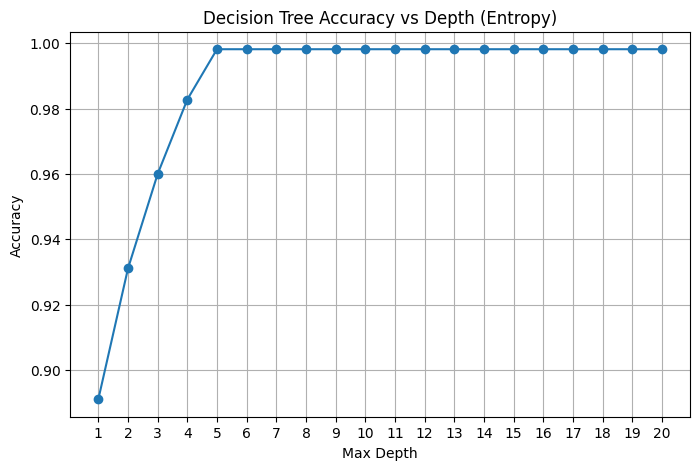

Best Decision Tree depth=5, test accuracy=0.9982


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
def train_model(x_train, y_train, criterion, tree_depth = None):
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth = tree_depth
    )
    clf.fit(x_train, y_train)
    return clf

def test_model(clf, x_test, y_test):
    pred = clf.predict(x_test)
    return accuracy_score(y_test, pred)

def vary_criterion(X_train, X_test, y_train, y_test):
    #Gini result
    clf = train_model(X_train, y_train, "gini")
    gini_acc = test_model(clf, X_test, y_test)
    #entropy result
    clf = train_model(X_train, y_train, "entropy")
    entr_acc = test_model(clf, X_test, y_test)

    print("gini accuracy: ", gini_acc)
    print("entropy accuracy: ", entr_acc)

def vary_depth(X_train, X_test, y_train, y_test, max_depth=20):
    depths = []
    accs = []
    best_acc = -1
    best_depth = None
    best_clf = None

    for d in range(1, max_depth + 1):
        clf = train_model(X_train, y_train, "entropy", d)
        acc = test_model(clf, X_test, y_test)

        depths.append(d)
        accs.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_depth = d
            best_clf = clf

    plt.figure(figsize=(8, 5))
    plt.plot(depths, accs, marker="o")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.title("Decision Tree Accuracy vs Depth (Entropy)")
    plt.xticks(depths)
    plt.grid(True)
    plt.show()

    print(f"Best Decision Tree depth={best_depth}, test accuracy={best_acc:.4f}")
    return best_clf, best_depth, best_acc

    
def problem1(df):

    y = df["class"]          # target
    X = df.drop(columns=["class"])   # features
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=0,
        stratify=y   # keeps class balance the same in train/test
    )
    # one-hot encode (fit on train only, transform both)
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    
    X_train_enc = enc.fit_transform(X_train)
    X_test_enc  = enc.transform(X_test)
    
    # now use these in your existing code
    vary_criterion(X_train_enc, X_test_enc, y_train, y_test)

    vary_depth(X_train_enc, X_test_enc, y_train, y_test)
problem1(mushroom_sample)


There was very little difference between gini accuracy and entropy accuracy. Both the same up to 64 bit precision.  

It looks like the model starts to overfit at depth = 5, at which point increasing the depth has no effect on test accuracy.


# 2. Random Forest

- Train Random Forest classifiers with different numbers of trees — e.g., `n_estimators ∈ {50, 100, 200}`.
- Compare their accuracy to your best single Decision Tree.
- Then, plot the top-10 most important features and discuss which mushroom traits seem most influential.

gini accuracy:  0.9981538461538462
entropy accuracy:  0.9981538461538462


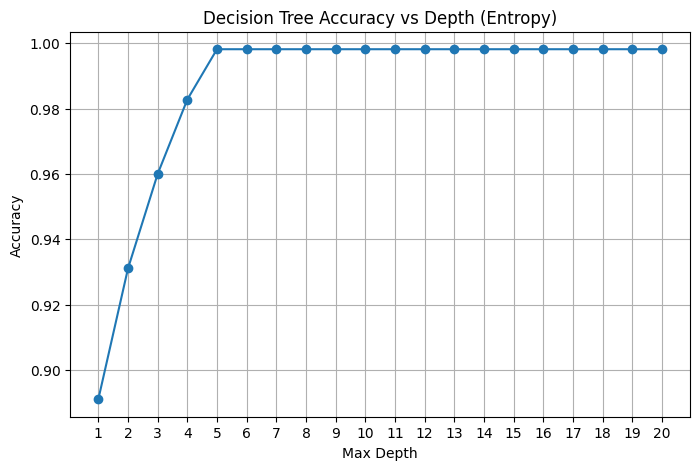

Best Decision Tree depth=5, test accuracy=0.9982
Random Forest (n_estimators=50) test accuracy = 1.0000
Random Forest (n_estimators=100) test accuracy = 1.0000
Random Forest (n_estimators=200) test accuracy = 1.0000
Best Random Forest n_estimators=50, test accuracy=1.0000

=== Summary ===
Best Decision Tree: depth=5, acc=0.9982
Best Random Forest: n_estimators=50, acc=1.0000


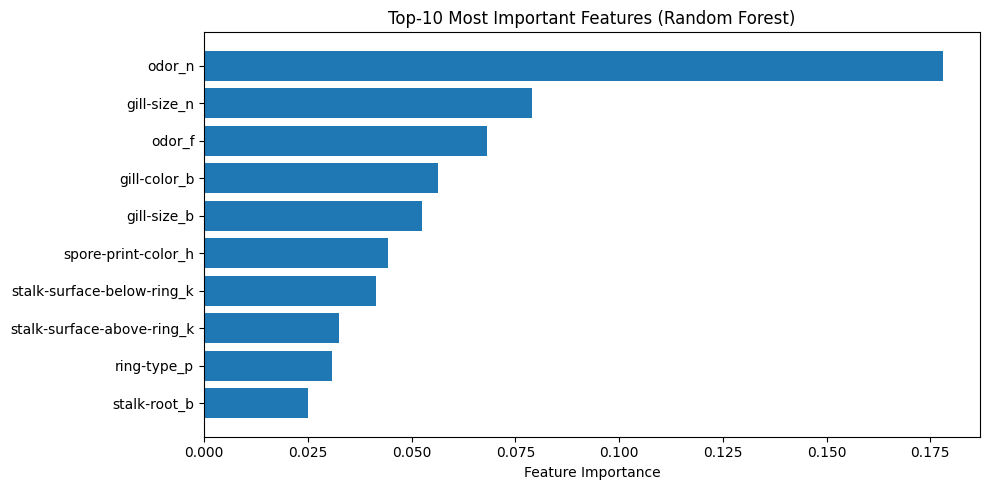

In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
def compare_random_forests(X_train, X_test, y_train, y_test, n_list=(50, 100, 200)):
    results = {}
    best_rf = None
    best_acc = -1
    best_n = None

    for n in n_list:
        rf = RandomForestClassifier(
            n_estimators=n,
            random_state=0,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        acc = test_model(rf, X_test, y_test)
        results[n] = acc
        print(f"Random Forest (n_estimators={n}) test accuracy = {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_rf = rf
            best_n = n

    print(f"Best Random Forest n_estimators={best_n}, test accuracy={best_acc:.4f}")
    return best_rf, best_n, best_acc, results

def plot_top10_importances(rf_model, encoder, top_k=10):
    importances = rf_model.feature_importances_
    feature_names = encoder.get_feature_names_out()

    idx = np.argsort(importances)[::-1][:top_k]
    top_features = feature_names[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(10, 5))
    plt.barh(top_features[::-1], top_importances[::-1])
    plt.xlabel("Feature Importance")
    plt.title(f"Top-{top_k} Most Important Features (Random Forest)")
    plt.tight_layout()
    plt.show()

def problem2(df):
    y = df["class"]
    X = df.drop(columns=["class"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )

    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_enc = enc.fit_transform(X_train)
    X_test_enc  = enc.transform(X_test)

    vary_criterion(X_train_enc, X_test_enc, y_train, y_test)

    best_tree, best_depth, best_tree_acc = vary_depth(X_train_enc, X_test_enc, y_train, y_test, max_depth=20)

    best_rf, best_n, best_rf_acc, rf_results = compare_random_forests(
        X_train_enc, X_test_enc, y_train, y_test, n_list=(50, 100, 200)
    )

    print("\n=== Summary ===")
    print(f"Best Decision Tree: depth={best_depth}, acc={best_tree_acc:.4f}")
    print(f"Best Random Forest: n_estimators={best_n}, acc={best_rf_acc:.4f}")

    plot_top10_importances(best_rf, enc, top_k=10)

problem2(mushroom_sample)

The random forests accuracy is essentially the same as that of the single decision tree.  
It seems that oder is by far the most important feature with gill size and and color being distant contenders.

# 3. Interpretability

- Train a small Decision Tree with max_depth=3 for easy visualization.
- Display the tree structure and manually trace 1–2 samples through the decision path.
- Explain in words why the model makes those predictions.
- Write 2-3 tests for your model, pretending that this is a model we are going to put in production. Why did you choose those tests? How confident are you that this model is going to succeed in production?
- Pretend that we are going to add a new feature: a textual description of the mushroom, written by an expert. What should we do with this feature? How can we use it to improve the decision tree?

Depth-3 Tree Accuracy: 0.96


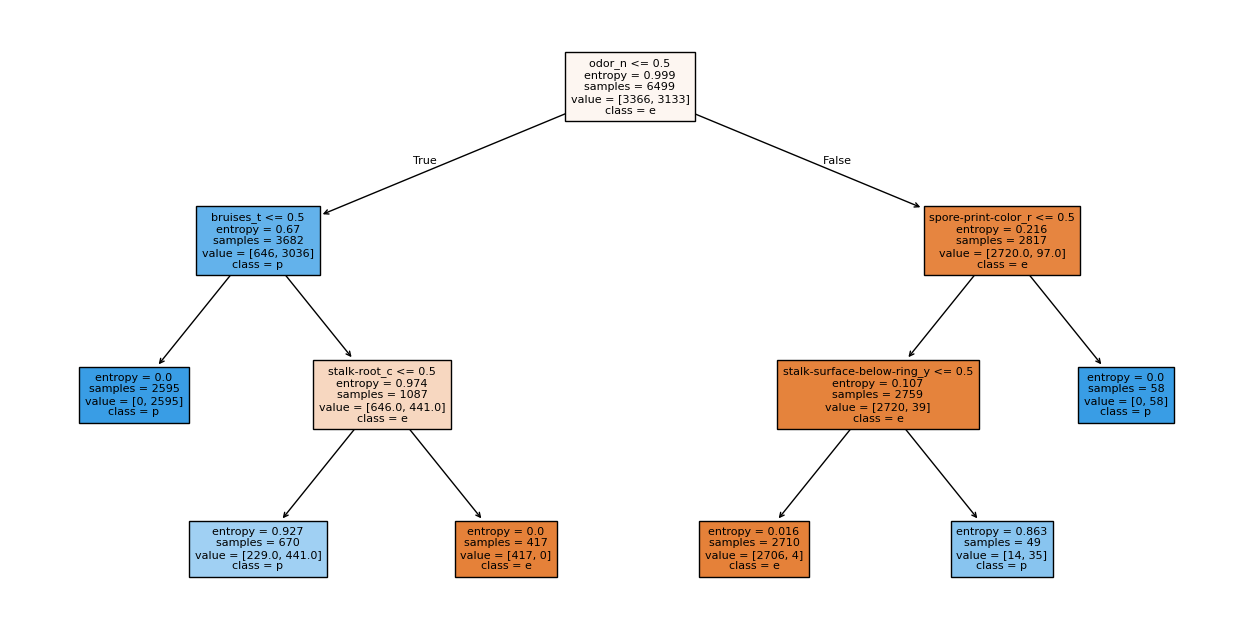

     class cap-shape cap-surface cap-color bruises odor gill-attachment  \
380      p         x           y         n       t    p               f   
3641     e         f           y         g       t    n               f   

     gill-spacing gill-size gill-color stalk-shape stalk-root  \
380             c         n          p           e          e   
3641            c         b          p           t          b   

     stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
380                         s                        s                      w   
3641                        s                        s                      g   

     stalk-color-below-ring veil-type veil-color ring-number ring-type  \
380                       w         p          w           o         p   
3641                      g         p          w           o         p   

     spore-print-color population habitat  
380                  k          s       u  
3641                 k 

In [25]:
from sklearn.tree import plot_tree


    
def problem3(df):
    y = df["class"]
    X = df.drop(columns=["class"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0, stratify=y
    )

    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_enc = enc.fit_transform(X_train)
    X_test_enc  = enc.transform(X_test)

    small_tree = train_model(X_train_enc, y_train, "entropy", tree_depth=3)
    test_min_accuracy(small_tree, X_test_enc, y_test)
    # Test accuracy
    acc = test_model(small_tree, X_test_enc, y_test)
    print("Depth-3 Tree Accuracy:", acc)

    feature_names = enc.get_feature_names_out()

    plt.figure(figsize=(16, 8))
    plot_tree(
        small_tree,
        feature_names=feature_names,
        class_names=small_tree.classes_,
        filled=True,
        fontsize=8
    )
    plt.show()
    return small_tree, X_test_enc, y_test, X_train_enc, y_train, enc

clf, X_test_enc, y_test, X_train_enc, y_train, enc = problem3(mushroom_sample)
pd.set_option('display.max_columns', None)
print(mushroom_sample.sample(2, random_state=0))
## test cases
def test_min_accuracy(clf, X_test_enc, y_test, min_acc=0.90):
    acc = test_model(clf, X_test_enc, y_test)
    assert acc >= min_acc, f"Accuracy too low: {acc:.3f} < {min_acc:.3f}"

def test_training_sanity(clf, X_train_enc, y_train, min_train_acc=0.85):
    train_acc = test_model(clf, X_train_enc, y_train)
    assert train_acc >= min_train_acc, f"Train acc too low: {train_acc:.3f} < {min_train_acc:.3f}"

def test_unseen_category_robustness(df, enc, clf):
    X_fake = df.drop(columns=["class"]).iloc[[0]].copy()
    col = X_fake.columns[0]
    X_fake[col] = "NEW_CAT_VALUE"
    X_fake_enc = enc.transform(X_fake)
    pred = clf.predict(X_fake_enc)[0]
    assert pred in clf.classes_, f"Prediction {pred} not in known classes {clf.classes_}"
    
test_min_accuracy(clf, X_test_enc, y_test)
test_training_sanity(clf, X_train_enc, y_train)
test_unseen_category_robustness(mushroom_sample, enc, clf)

## Tracing
sample 380: odor is n, so we travel to the right (false). Sport print color is not r so we go right (false). The model concludes that sample 380 is poisonous, which is correct.  
The trace above clearly outlines how the model is making decisions. How the model came to these nodes / edges in the decision tree is by minimizing the amount of entropy at each node.  
## Testing
I included tests for minimum test accuracy, minimum training accuracy, and robustness. Test accuracy ensures that we don't deploy a model that doesn't have worse than 90% accuracy. Minimum training accuracy ensures that we don't deploy a model that wasn't able to learn from the training data. The robustness test ensures that if we accidentally add a new column in production, the model doesn't crash.  
## Text data
Decision trees aren't designed to handle variable length text data, so we would have to convert the notes to categorical / numerical features. For instance, we could use the length of the note as a feature, and we could have various categories for whether or not the note contains certain words like "poisonous" or "red". As long as the notes provided by the expert are consistent and don't use a lot of "not" statements (like, "not poisonous"), the accuracy of our model should improve.

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- ChatGPT: For problem one, ChatGPT gave me the necessary information about the scikit decision tree api to answer the question. For problem 2, ChatGPT wrote the code for random forests and for graphing. For problem 3, chatGPT wrote the code for visualizing the tree and also for the test cases.
```

# B [24pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[8pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[4pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
If a model performs well on training data but poorly on test data, how would you explain the issue and fix it?


This implies that the model is overfitting, meaning that it is fitting too tightly to the training data.  
You can liken this as an issue where you are using a polynomial of degree 25 to estimate the curve connecting 24 points, you may end up with a residual error of 0, but your curve does not interpolate or extrapolate well.  
With decision trees, you can attempt to fix this be decreasing the max tree depth, or, if you are using random forests, reduce the number of estimators.

# 2.
Why do deep decision trees often achieve near perfect training accuracy?

Deep decision trees achieve near perfect training accuracy because they can account for every possible combination of features. For instance, if you have a dataset with $m$ binary columns, you have $2^m$ possible data points. A decision tree of height $m + 1$ can have a leaf node for each data point, since the total number of leaves would be $2^{(m+1)-1}$

# 3.
What do you do when the model fits in memory but the data does not? What if neither fits?

If the model fits in memory but the data does not, you could repeatedly train the model on samples of the dataset, so you:  
1. load a sample of the data into memory
2. train the model
3. save the model
4. load a new sample
5. load the saved model
6. train the saved model with the new data
7. repeat 4 -> 6 until all data has been seen

If neither fits into memory, well you can configure Disk as Swap and accept the slower training speed, or use distributed training.

# 4.
If entropy and Gini give different trees, which one is correct?

If entropy and Gini give different trees, neither is necessarily always correct. You should choose to deploy whichever one yields the better test accuracy, or you can ensemble them.  

# 5. 
If your model fails in production, but passed all offline tests, what do you suspect first?

I would assume that the production data has drifted or is not being pre-processed correctly. If we apply encodings in training / testing that we don't apply in production, we will get runtime exceptions from scipy for having columns without valid encodings.

# 6.
Why does a shallow tree sometimes outperform a deep one?

A shallow tree can outperform a deep one if you have columns that have no real correlation to the label.  
For instance, a shallow tree will ignore columns that have little correlation with labels, whereas a deeper tree is forced to use these columns.  
Thus, using our mushroom dataset as an example, if you had a column for the date that the observation occured, this column obviously should not have any impact on the prediction of whether or not a mushroom is poisonous. A shallow tree would safely be able to ignore this feature. A deeper tree however may mistakenly use this feature as a way to predict whether nor not a mushroom is poisonous, which is obviously erroneous.

# 7.
What's worse: missing values or incorrect values in your training datset?

Incorrect values in a training dataset are much worse because it is much more difficult to find incorrect values vs missing values.  
For instance, using our mushroom dataset, we could have incorrectly entered values for odor_n but we would have no way to determine this without observing the mushrooms again. A missing value on the other hand can be dealt with. You can either choose to throw out the row with the missing value, or you can replace the value with an average or placeholder.

# 8.
(Video; 1 minute max) Why are decision trees still widely used despite deep learning?

https://drive.google.com/file/d/1cIkgpIOss5d6hLeEihmccceSEktsI1Fi/view?usp=sharing

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- none
```

# C [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have after this homework? Or, what topics are you curious about now? List at least 3.

what should you do when model and data don't fit in ram? 

how to train decision trees in a distributed manner?

is training decision trees easy to parallelize?

```
On my honor, I declare the following resources:
1. Collaborators:
- None

2. Web Sources:
- None

3. AI Tools:
- none
```